# Baseline model

This notebook is used to train a simple baseline XGBoost model to compare against the more advanced models that we use in our project.

This notebook is an adaptation of the `segment_aerial_images.ipynb` notebook that was provided to us in the [CS-443 course GitHub](https://github.com/epfml/ML_course/blob/master/projects/project2/project_road_segmentation/segment_aerial_images.ipynb).

In [1]:
import sklearn.metrics
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

In [2]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
import os
import glob

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str: 
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive = True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('baseline_model.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

In [4]:
# Helper functions


def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

In [5]:
# Loaded a set of images
#root_dir = "training/"
root_dir = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

image_dir = os.path.join(root_dir, 'images')
files = os.listdir(image_dir)
n = min(80, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
#imgs = [load_image(image_dir + files[i]) for i in range(n)]
imgs = [load_image(os.path.join(image_dir, files[i])) for i in range(n)]
print(files[0])

gt_dir = os.path.join(root_dir, 'masks')
print("Loading " + str(n) + " images")
#gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
gt_imgs = [load_image(os.path.join(gt_dir, files[i])) for i in range(n)]
print(files[0])

n = 10  # Only use 10 images for training

Loading 80 images
satImage_058.png
Loading 80 images
satImage_058.png


Image size = 400,400


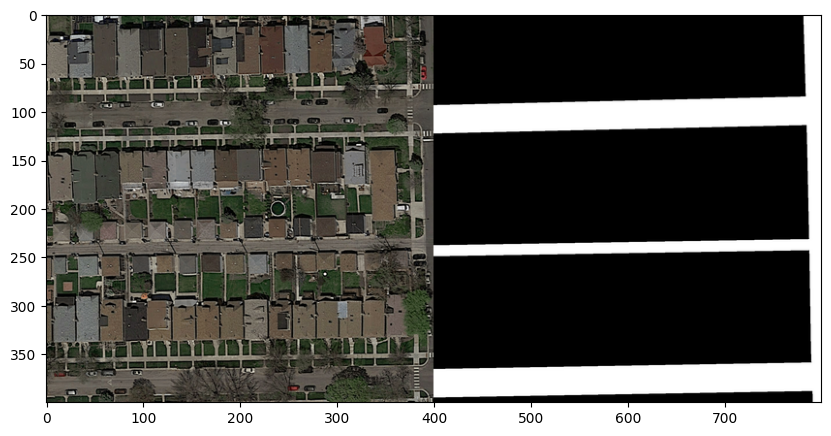

In [6]:
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

In [7]:
# Extract patches from input images
patch_size = 16  # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

In [8]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0, 1))
    feat_v = np.var(img, axis=(0, 1))
    feat = np.append(feat_m, feat_v)
    return feat


# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat


# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray(
        [extract_features(img_patches[i]) for i in range(len(img_patches))]
    )
    return X

In [9]:
# Compute features for each image patch
foreground_threshold = (
    0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
)


def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0


X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [10]:
# Print feature statistics

print("Computed " + str(X.shape[0]) + " features")
print("Feature dimension = " + str(X.shape[1]))
print("Number of classes = " + str(np.max(Y)))  # TODO: fix, length(unique(Y))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print("Class 0: " + str(len(Y0)) + " samples")
print("Class 1: " + str(len(Y1)) + " samples")

Computed 6250 features
Feature dimension = 6
Number of classes = 1
Class 0: 4862 samples
Class 1: 1388 samples


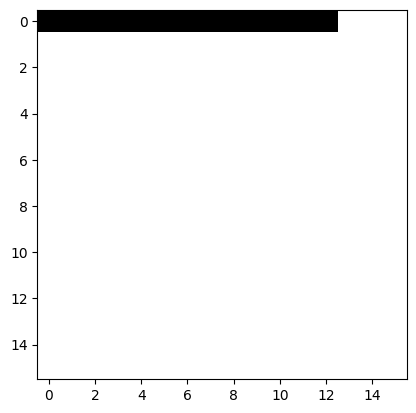

In [11]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap="Greys_r")

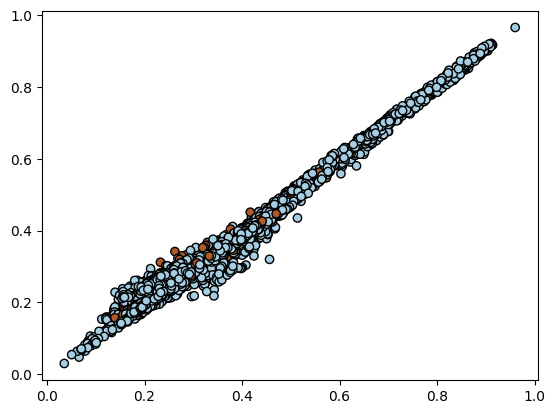

In [12]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)

## Train Logistic Regression model

In [130]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
model = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
model.fit(X, Y)



LogisticRegression(C=100000.0, class_weight='balanced')

## Train sklearn GradientBoosting model

In [137]:
from sklearn import ensemble

model = ensemble.GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=10, random_state=0)
model.fit(X, Y)

GradientBoostingClassifier(learning_rate=1.0, max_depth=10, n_estimators=500,
                           random_state=0)

## Train XGBoost model

In [147]:
from flaml import AutoML
from flaml.automl.data import load_openml_dataset

# Download [houses dataset](https://www.openml.org/d/537) from OpenML. The task is to predict median price of the house in the region based on demographic composition and a state of housing market in the region.
#X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=537, data_dir='./')

automl = AutoML()
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune XGBoost in this example
    "task": 'classification',  # task type
    "seed": 7654321,  # random seed
}
automl.fit(X_train=X, y_train=Y, **settings)

model = automl

[flaml.automl.logger: 12-05 16:04:38] {1679} INFO - task = classification
[flaml.automl.logger: 12-05 16:04:38] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 12-05 16:04:38] {1788} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-05 16:04:38] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-05 16:04:38] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-05 16:04:39] {2344} INFO - Estimated sufficient time budget=1264s. Estimated necessary time budget=1s.
[flaml.automl.logger: 12-05 16:04:39] {2391} INFO -  at 0.1s,	estimator xgboost's best error=0.2221,	best estimator xgboost's best error=0.2221
[flaml.automl.logger: 12-05 16:04:39] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 12-05 16:04:39] {2391} INFO -  at 0.2s,	estimator xgboost's best error=0.2221,	best estimator xgboost's best error=0.2221
[flaml.automl.logger: 12-05 16:04:39] {2218} INFO - iteration 2, current learn

## Train simple CNN model

In [23]:
import os
import cv2
import torch
import albumentations as A
import pandas as pd
import numpy as np
import itertools
import segmentation_models_pytorch as smp
import time
import random

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model
from torch.utils.data import DataLoader, SubsetRandomSampler
from IPython.display import clear_output

from scripts.training import train_model


get_mlp = lambda image_size: torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(image_size * image_size, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
)

get_cnn = lambda image_size: torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, 5, stride=2, padding=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, 5, stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 128, 5, stride=2, padding=2),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Conv2d(128, image_size, 1),
    torch.nn.Flatten(),
)

#### Datasets

SEED = 16
N_CPU = os.cpu_count()
N_EPOCHS = 100
BATCH_SIZE = 1

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE,
    'num_workers': N_CPU,
    'persistent_workers': True
}

# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')
image_path_train, _, mask_path_train, _ = split_data(train_directory, test_size=0)

train_dataset = RoadDataset(image_path_train, mask_path_train)

base_tf = [A.Resize(height=608, width=608, always_apply=True)]

train_tf = A.Compose(base_tf)
valid_tf = A.Compose(base_tf)

train_loader = DataLoader(train_dataset.set_tf(train_tf), **LOADER_PARAMS)
valid_loader = DataLoader(train_dataset.set_tf(valid_tf), **LOADER_PARAMS)

random.seed(SEED)
np.random.seed(SEED)


#### Model setup
model_ = get_cnn(608)
model_.to("cpu")
criterion_ = f1_score
optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)


# Train model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model_, (train_loader, valid_loader), criterion_, optimizer_, None, N_EPOCHS
)

  0%|          | 0/100 [00:01<?, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f965440feb0>
Traceback (most recent call last):
  File "/home/siimm/repod/ml-project-2-odds-oddities/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/siimm/repod/ml-project-2-odds-oddities/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [148]:
# Predict on the training set
Z = model.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print("True positive rate = " + str(TPR))


True positive rate = 0.0952


In [149]:
from sklearn.metrics import f1_score

f1_score(Y, Z, zero_division='warn')

0.5674773485932284

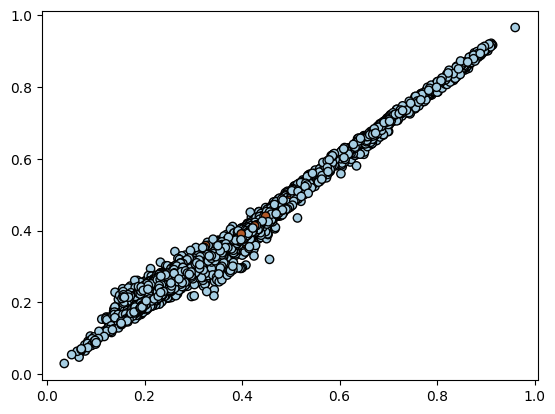

In [150]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors="k", cmap=plt.cm.Paired)

In [151]:
# Convert array of labels to an image


def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

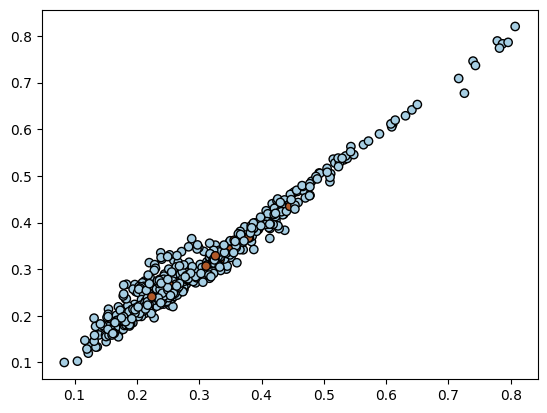

In [152]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features( os.path.join(image_dir, files[img_idx]))
Zi = model.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors="k", cmap=plt.cm.Paired)

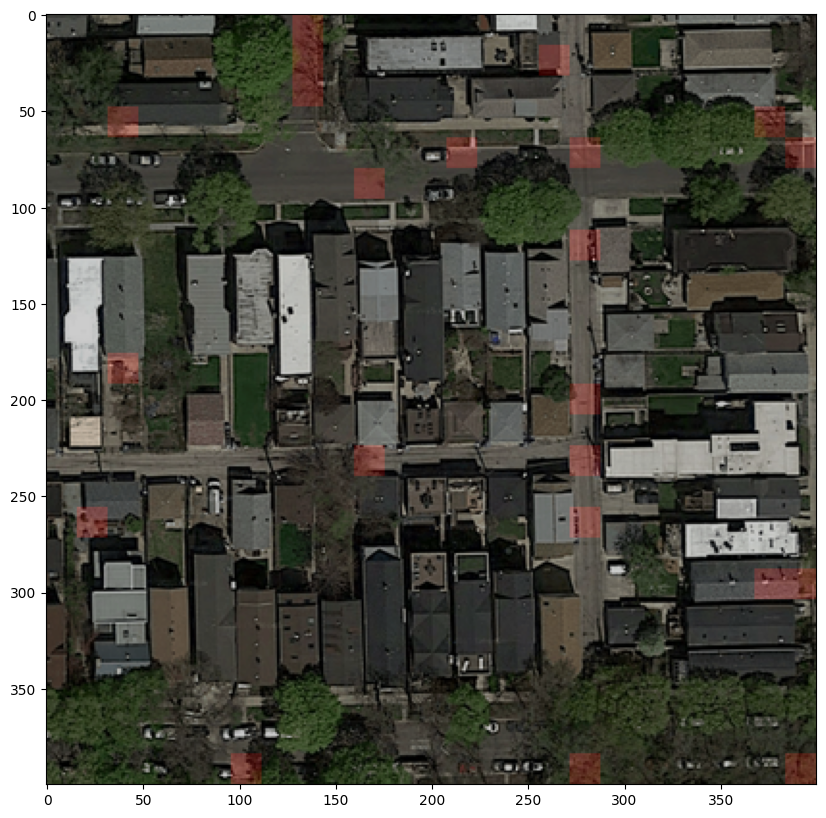

In [153]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)